Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tensorflow Pretrained BERT on Azure Machine Learning
This notebook contains an end-to-end walkthrough of using Azure Machine Learning Service to run [Google's TensorFlow repository for the BERT model](https://github.com/google-research/bert).

You will find the following contents:
- Download pretrained TensorFlow BERT checkpoint and GLUE dataset on the remote compute and store them in Azure storage
- Speep-up fine-tuning BERT for GLUE dataset on AzureML GPU clusters
- Further fine-tune BERT wtih AzureML hyperparameter optimizer 

## Prerequisites
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning (AML)
* If you are running in your own environment, follow [SDK installation instructions](https://docs.microsoft.com/azure/machine-learning/service/how-to-configure-environment).

In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.18


## Initialize workspace

To create or access an Azure ML Workspace, you will need to import the AML library and the following information:
* A name for your workspace
* Your subscription id
* The resource group name

Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step or create a new one. 

In [2]:
import azureml.core
import os
from azureml.core import Workspace

subscription_id = os.getenv("SUBSCRIPTION_ID", default="")
resource_group = os.getenv("RESOURCE_GROUP", default="")
workspace_name = os.getenv("WORKSPACE_NAME", default="")
workspace_region = os.getenv("WORKSPACE_REGION", default="")


try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config(file_name="BERT_AML_config.json")
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except:
    print("Workspace not accessible. Change your parameters or create a new workspace below")

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Wrote the config file BERT_AML_config.json to: F:\AzureML-BERT\TensorFlow\aml_config\BERT_AML_config.json
Workspace configuration succeeded. Skip the workspace creation steps below


## Download Model and GLUE dataset on the remote compute

We will download the model and store it in an Azure Blob container. We will also download the [GLUE data](https://gluebenchmark.com/tasks) by running the [script](https://gist.github.com/W4ngatang/60c2bdb54d156a41194446737ce03e2e) and unpack it to the same Azure Blob container.

All of the above steps will be done in a remote AzureML cluster.

### Create a project directory
Create a directory that will contain all the necessary code from your local machine that you will need access to on the remote resource. This includes the training script and any additional files your training script depends on.

In [3]:
import os

project_folder = './bert'
os.makedirs(project_folder, exist_ok=True)

Make a local clone of the original repository

In [4]:
os.system('git clone https://github.com/google-research/bert.git')

128

We have prepared a python script [download_model_and_dataset.py](download_model_and_dataset.py) to do the following tasks:
- Download [the pre-trained models released by Google](https://github.com/google-research/bert#pre-trained-models) to local directory
- Dump model and its metadata into a mounted Azure Blob container
- Run the [script](https://gist.github.com/W4ngatang/60c2bdb54d156a41194446737ce03e2e) to download the [GLUE data](https://gluebenchmark.com/tasks) in the mounted Azure Blob container


In [5]:
import shutil
shutil.copy('download_model_and_dataset.py', project_folder)

'./bert\\download_model_and_dataset.py'

### Define AzureML datastore to collect converted model file

To make data accessible for remote training, AML provides a convenient way to do so via a [Datastore](https://docs.microsoft.com/azure/machine-learning/service/how-to-access-data). The datastore provides a mechanism for you to upload/download data to Azure Storage, and interact with it from your remote compute targets.

Each workspace is associated with a default Azure Blob datastore named `'workspaceblobstore'`. In this work, we use this default datastore to collect the converted model file and the GLUE training dataset .

In [6]:
from azureml.core import Datastore
ds = Datastore(ws, 'workspaceblobstore')

### Create an experiment
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) to track all the runs in your workspace for this tutorial. 

In [7]:
from azureml.core import Experiment

experiment_name = 'BERT_TF'
experiment = Experiment(ws, name=experiment_name)

### Create a Tensorflow estimator
The AML SDK's Tensorflow estimator enables you to easily submit Tensorflow training jobs for both single-node and distributed runs. For more information on the Tensorflow estimator, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-train-tensorflow). The entry script `download_model_and_dataset.py` takes model name variable:

- BERT-Base, Uncased: 12-layer: `uncased_L-12_H-768_A-12`
- BERT-Large, Uncased: `uncased_L-24_H-1024_A-16`
- BERT-Base, Cased: `cased_L-12_H-768_A-12`
- BERT-Base, Multilingual: `multilingual_L-12_H-768_A-12`
- BERT-Base, Chinese: `chinese_L-12_H-768_A-12`

In [8]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--bert_model_name': 'uncased_L-12_H-768_A-12',
    '--model_dump_path': ds.path('BERT_model/uncased_L-12_H-768_A-12').as_mount(),
    '--glue_data_path': ds.path('glue_data_path').as_mount()
}

estimator = TensorFlow(source_directory=project_folder,
                    vm_size='STANDARD_D2_v2',
                    script_params=script_params,
                    entry_script='download_model_and_dataset.py',
                    node_count=1,
                    use_gpu=False)

The above code defines a CPU cluster with `vm_size` of `STANDARD_D2_V2`. We do not need GPU cluster for data movement tasks.

### Submit and Monitor your run
Run your experiment by submitting your estimator object. The widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [9]:
run = experiment.submit(estimator)
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

## Fine-tuning with BERT and GLUE dataset
As our `BERT` model and `GLUE` dataset are ready in Azure storage, we can start to fine-tune the model on a single node using a GPU. 

### Create a Tensorflow estimator for fine-tuning
Let us create a new Tensorflow estimator to run the fine-tuning script `run_classifier.py`, that is already provided at [the original repository](https://github.com/google-research/bert/blob/master/run_classifier.py). Please refer [here](https://github.com/google-research/bert#sentence-and-sentence-pair-classification-tasks) for more detail about the script. A `STANDARD_NC6` vm_size is used, which has 1 GPU.


In [10]:
from azureml.train.dnn import TensorFlow

ft_estimator = TensorFlow(source_directory=project_folder,
                    vm_size='STANDARD_NC6',
                    script_params = {
                          '--task_name': 'MRPC',
                          '--do_train' : True,
                          '--do_eval': True,
                          '--data_dir': ds.path('glue_data_path/MRPC/').as_mount(),
                          '--vocab_file': ds.path('BERT_model/uncased_L-12_H-768_A-12/vocab.txt').as_mount(),
                          '--bert_config_file': ds.path('BERT_model/uncased_L-12_H-768_A-12/bert_config.json').as_mount(),
                          '--init_checkpoint': ds.path('BERT_model/uncased_L-12_H-768_A-12/bert_model.ckpt').as_mount(),
                          '--max_seq_length': 128,
                          '--train_batch_size': 32,
                          '--learning_rate': 2e-5,
                          '--num_train_epochs': 3.0,
                          '--output_dir': './outputs'
                    },
                    entry_script='run_classifier.py',
                    use_gpu=True)

### Submit and Monitor your run

In [11]:
run = experiment.submit(ft_estimator)
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

## Fine-Tuning BERT with Hyperparameter Tuning

We would also like to optimize our hyperparameter, `learning rate`, using Azure Machine Learning's hyperparameter tuning capabilities.

To use AML's tracking and metrics capabilities, we need to add a small amount of AzureML code inside the training script.

In `run_classifier.py`, we will log some metrics to our AML run. To do so, we will access the AML run object within the script:
```Python
from azureml.core.run import Run
run = Run.get_context()
```
Further within `run_classifier.py`, we log the learning rate, and the epoch training and eval loss the model achieves:
```Python
run.log('lr', np.float(args.learning_rate))

run.log('train_mean_loss', mean_loss)
run.log('eval_mean_loss', mean_loss)
run.log('train_example_loss', mean_loss)
run.log('eval_example_loss', mean_loss)
```
These run metrics will become particularly important when we begin hyperparameter tuning our model in the "Tune model hyperparameters" section.

Let's first copy the modified [run_classifier.py](./run_classifier.py) into our local project directory

In [12]:
shutil.copy('run_classifier.py', project_folder)

'./bert\\run_classifier.py'

### Start a hyperparameter sweep
First, we will define the hyperparameter space to sweep over. In this example we will use random sampling to try different configuration sets of hyperparameter to maximize our primary metric, the mean training loss (`train_mean_loss`).  We specify a `loguniform` distribution for the learning rate parameter since we want to evenly space the samples over a range that varies by a few orders of magnitude, ~1e-4 to ~1e-6.

Then, we specify the early termination policy to use to early terminate poorly performing runs. Here we use the `BanditPolicy`, which will terminate any run that doesn't fall within the slack factor of our primary evaluation metric. In this tutorial, we will apply this policy every epoch (since we report our `train_mean_loss` metric every epoch and `evaluation_interval=1`). 
Refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-tune-hyperparameters#specify-an-early-termination-policy) for more information on the BanditPolicy and other policies available.

In [19]:
from azureml.train.hyperdrive import *

param_sampling = RandomParameterSampling( {
        'learning_rate': loguniform(-14, -9),
    }
)

policy = BanditPolicy(delay_evaluation=25, evaluation_interval=1, slack_amount=0.10)

hyperdrive_run_config = HyperDriveRunConfig(estimator=ft_estimator,
                                            hyperparameter_sampling=param_sampling, 
                                            primary_metric_name='train_mean_loss',
                                            primary_metric_goal=PrimaryMetricGoal.MINIMIZE,
                                            policy=policy,
                                            max_total_runs=8,
                                            max_concurrent_runs=2)

Finally, lauch the hyperparameter tuning job.

In [20]:
hyperdrive_run = experiment.submit(hyperdrive_run_config)

### Monitor Hyper Parameter Tuning runs
We can monitor the progress of the runs with the following Jupyter widget. You will get something like below in Jupyter Notebook:

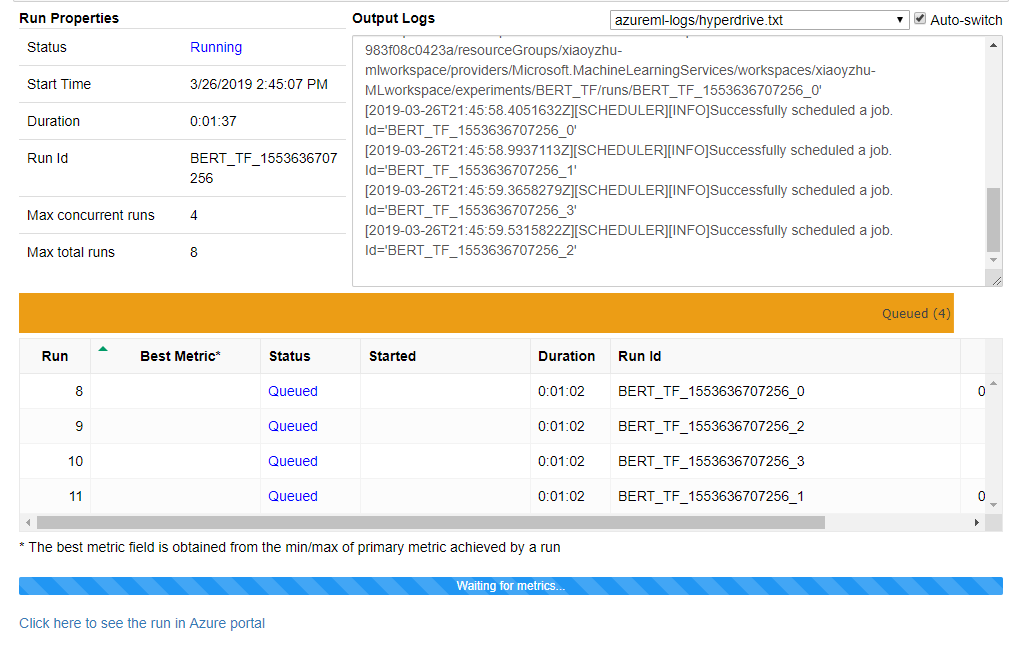

In [21]:
from azureml.widgets import RunDetails

RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO',…

### Find and register the best model
Once all the runs complete, we can find the run that produced the model with the highest accuracy.

In [ ]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
print(best_run)
print('Best Run is:\n  Validation accuracy: {0:.5f} \n  Validation loss: {1:.5f} \n  Learning rate: {2:.8f}'.format(
        best_run_metrics['eval_accuracy'],
        best_run_metrics['loss'],
        best_run_metrics['lr']
     ))

You can compare the resulting optimal `learning_rate` with the value suggested by the [original implementation hyper-parameters](https://github.com/google-research/bert#sentence-and-sentence-pair-classification-tasks): 2e-5
